## Environment Configuration

In [1]:
!pip install -U emoji
!pip install -U tqdm
!pip install -U transformers
!pip install -U kaleido
!pip install -U dash
!pip install -U optuna
!pip install -U scikit-learn
!pip install -U wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 32.2 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 9.5 MB/s eta 0:00:00
     

In [2]:
# General Dataloaders
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
# NLP
import re
import string
import emoji
from collections import Counter
from transformers import pipeline
# Data Visualization
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
# Machine Learning
import torch
# Data Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
# Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
# Models
from sklearn.ensemble import RandomForestClassifier
import joblib
# Hyperparameter Tuning
import optuna
from optuna.storages import JournalStorage, JournalFileStorage
import matplotlib.pyplot as plt
# Logistics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from timeit import default_timer as timer

In [3]:
dv = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(dv)

cpu


## Augmentation Functions

In [ ]:
def clean_text(x: str) -> str:
  """
  Goals:
    1) Remove punctuation to make the TF-IDF dictionary more accurate
    2) Remove emojis, they are unnecessary here for training purposes. (We will use emoji data in another column :3)
  """
  clean_text = x.translate(str.maketrans('', '', string.punctuation))
  clean_text = emoji.replace_emoji(clean_text, replace='')
  return clean_text

In [ ]:
def num_emojis(x: str) -> int:
  return emoji.emoji_count(x)

In [ ]:
def average_words_per_sentence(message: str):
  """
  Unfortunately, due to the limitation of a non-standard ASCII table for emojis, getting the
  average words per second is not 100% accurate in certain cases.

  Please modify the regular expression for, 'sentences' to match your need if you re-use this code. Thanks :)
  """
  # Split the string based on {., !, ?} characters
  # print(f'Base Message: {message}')
  sentences = re.split('[.!?\u263a-\U0001f645\n]+', message.strip().replace('\n', ''))
  avg_words = 0
  for entry in sentences:
    # print(f'Entry: {entry}')
    words = re.split('[,;: ]', entry.strip())
    # print(f'Words: {words}')
    avg_words += len(words)
  return round(avg_words / len(sentences), 2)

In [ ]:
sentiment = pipeline(
    task='sentiment-analysis',
    model= "cardiffnlp/twitter-roberta-base-sentiment-latest", #@param {type:"string"},
    tokenizer = "cardiffnlp/twitter-roberta-base-sentiment-latest", #@param {type:"string"}
    max_length=512,
    batch_size = 25000,
    truncation=True,
    padding=True,
    device=dv
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

## Data Loader

In [5]:
messages = pd.read_csv('/content/drive/MyDrive/Graduate/Research/SU24/Suicide/Code/Datasets/Suicide_Detection.csv')

In [ ]:
messages.tail()

,Unnamed: 0,text,class
232069,348103,If you don't like rock then your not going to ...,non-suicide
232070,348106,You how you can tell i have so many friends an...,non-suicide
232071,348107,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide
232072,348108,The usual stuff you find hereI'm not posting t...,suicide
232073,348110,I still haven't beaten the first boss in Hollo...,non-suicide


## Data Augmentation

In [ ]:
clean_text = messages['text'].progress_apply(lambda x: clean_text(x))

100%|██████████| 232074/232074 [02:47<00:00, 1388.48it/s]


In [ ]:
average_words_per_sentence = messages['text'].progress_apply(lambda x: average_words_per_sentence(x))

100%|██████████| 232074/232074 [00:14<00:00, 16094.06it/s]


In [ ]:
num_emojis = messages['text'].progress_apply(lambda x: num_emojis(x))

100%|██████████| 232074/232074 [02:27<00:00, 1568.97it/s]


In [ ]:
messages.insert(len(messages.columns) - 1, "clean_text", clean_text)
messages.insert(len(messages.columns) - 1, "average_words_per_sentence", average_words_per_sentence)

In [ ]:
sentiment = messages['clean_text'].progress_apply(lambda x: sentiment(x)[0]['label'])

  0%|          | 8/232074 [00:02<13:21:12,  4.83it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 232074/232074 [55:30<00:00, 69.69it/s]


In [ ]:
messages.insert(len(messages.columns) - 1, "sentiment", sentiment)
messages.insert(len(messages.columns) - 1, "num_emojis", num_emojis)

In [ ]:
messages.to_parquet('/content/drive/MyDrive/Graduate/Research/SU24/Suicide/Code/Datasets/UPDATED_Suicide_Detection.csv')

In [ ]:
messages.tail()

,Unnamed: 0,text,clean_text,average_words_per_sentence,sentiment,num_emojis,class
232069,348103,If you don't like rock then your not going to ...,If you dont like rock then your not going to g...,7.33,negative,0,non-suicide
232070,348106,You how you can tell i have so many friends an...,You how you can tell i have so many friends an...,15.50,positive,0,non-suicide
232071,348107,pee probably tastes like salty tea😏💦‼️ can som...,pee probably tastes like salty tea can someone...,3.40,negative,5,non-suicide
232072,348108,The usual stuff you find hereI'm not posting t...,The usual stuff you find hereIm not posting th...,31.42,negative,0,suicide
232073,348110,I still haven't beaten the first boss in Hollo...,I still havent beaten the first boss in Hollow...,8.50,negative,0,non-suicide


## Data Analytics & Visualization

In [9]:
messages = pd.read_parquet('/content/drive/MyDrive/Graduate/Research/SU24/Suicide/Code/Augments/UPDATED_Suicide_Detection.csv.parquet.gzip')

In [10]:
targets = Counter(messages['class'])
fig = px.pie(
    names = targets.keys(),
    values = targets.values()
)

fig.update_layout(
    title="Distribution of Dataset Labels",
    font_family="Courier New",
    title_font_family="Courier New",
    font_size=24
)

fig.show()

In [11]:
test = Counter(messages['sentiment'])
fig = px.pie(
    names = test.keys(),
    values = test.values()
    )
fig.update_layout(
    title="Sentiment Analysis of Messages",
    font_family="Courier New",
    title_font_family="Courier New",
    font_size=24
)

fig.show()

In [23]:
"""
RQ: Is there a relationship between emoji usage and the type of message?
"""

suicide_messages = messages.loc[messages['class'] == 'suicide']

suicide_emojis = Counter()
for message in tqdm(suicide_messages['text']):
  suicide_emojis += Counter(list(entry['emoji'] for entry in emoji.emoji_list(message)))
suicide_emojis = suicide_emojis.most_common(10)

100%|██████████| 116037/116037 [02:28<00:00, 780.10it/s]


In [13]:
plot_emojis = {}
for entry in suicide_emojis:
  plot_emojis[entry[0]] = entry[1]

In [14]:
fig = px.bar(
    x = plot_emojis.keys(),
    y = plot_emojis.values(),
)

fig.update_layout(
    title="Top 10 Emojis Used in Suicidal Messages",
    xaxis_title="Emoji",
    yaxis_title="Count",
    font_family="Courier New",
    title_font_family="Courier New",
    font_size=24
)

fig.show()

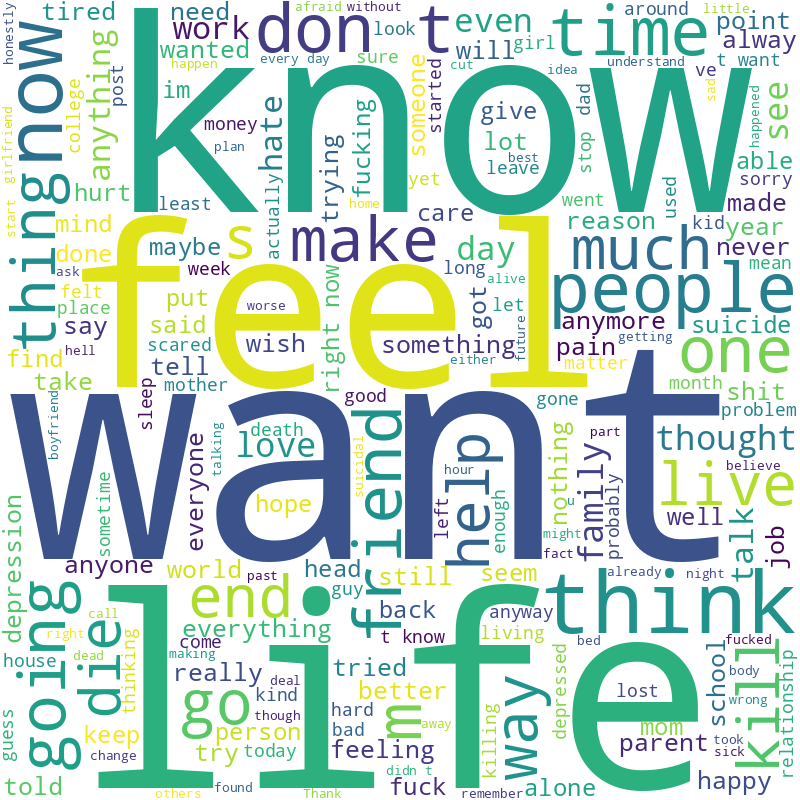

In [24]:
wv_all_tweets = WordCloud(
    background_color='white',
    width=800,
    height=800,
    stopwords=set(STOPWORDS),
    max_words=2500,
    min_font_size=12,
    random_state=2
)
wv_all_tweets.generate(' '.join(suicide_messages['text'].dropna()))
wv_all_tweets.to_image()

In [25]:
"""
RQ: Is there a relationship between emoji usage and the type of message?
"""

control_messages = messages.loc[messages['class'] == 'non-suicide']

control_emojis = Counter()
for message in tqdm(control_messages['text']):
  control_emojis += Counter(list(entry['emoji'] for entry in emoji.emoji_list(message)))
control_emojis = control_emojis.most_common(10)

100%|██████████| 116037/116037 [01:00<00:00, 1911.41it/s]


In [18]:
plot_emojis = {}
for entry in control_emojis:
  plot_emojis[entry[0]] = entry[1]

In [19]:
fig = px.bar(
    x = plot_emojis.keys(),
    y = plot_emojis.values(),
)

fig.update_layout(
    title="Top 10 Emojis Used in Non-Suicidal Messages",
    xaxis_title="Emoji",
    yaxis_title="Count",
    font_family="Courier New",
    title_font_family="Courier New",
    font_size=24
)

fig.show()

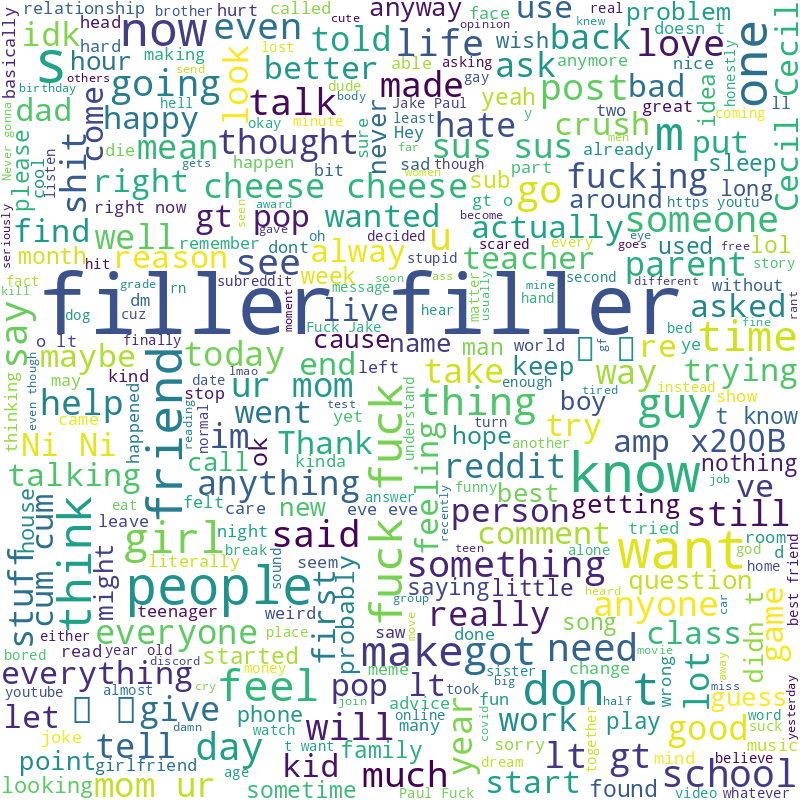

In [26]:
wv_all_tweets = WordCloud(
    background_color='white',
    width=800,
    height=800,
    stopwords=set(STOPWORDS),
    max_words=2500,
    min_font_size=12,
    random_state=2
)
wv_all_tweets.generate(' '.join(control_messages['text'].dropna()))
wv_all_tweets.to_image()